project: 3.4528096099109395e-07
desifast: 4.3100973070041887e-07
specutils: 3.452794925563749e-07
interp1d: 3.4538289763405394e-07
original: 3.4540781564573915e-07
3600.0 9800.0


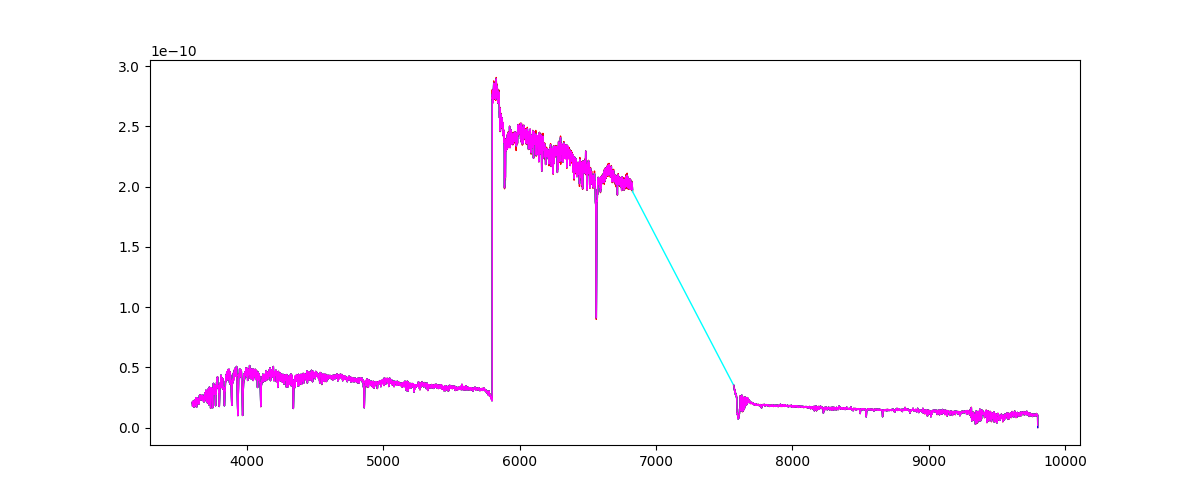

In [1]:
import numpy
import lvmdrp.core.resample as resample
import matplotlib.pyplot as plt
from scipy import interpolate
from astropy.io import fits

def interpolate_mask(x, y, mask, kind="linear", fill_value=0):
    """
    :param x, y: numpy arrays, samples and values
    :param mask: boolean mask, True for masked values
    :param method: interpolation method, one of linear, nearest,
    nearest-up, zero, slinear, quadratic, cubic, previous, or next.
    :param fill_value: which value to use for filling up data outside the
        convex hull of known pixel values.
        Default is 0, Has no effect for 'nearest'.
    :return: the image with missing values interpolated
    """
    if not numpy.any(mask):
        return y
    known_x, known_v = x[~mask], y[~mask]
    missing_x = x[mask]
    missing_idx = numpy.where(mask)

    f = interpolate.interp1d(known_x, known_v, kind=kind, fill_value=fill_value, bounds_error=False)
    yy = y.copy()
    yy[missing_idx] = f(missing_x)

    return yy



with fits.open("/Users/droryn/work/LVM/data/sas/sdsswork/lvm/spectro/redux/1.1.0dev/1039XX/1039949/60356/lvmCFrame-00012618.fits") as hdu:
    s1 = hdu['FLUX'].data
    d1 = hdu['IVAR'].data
    w1 = hdu['WAVE'].data

f = 1022
f = 1513
s1 = s1[f,:]
d1 = d1[f,:]

%matplotlib widget
# vega = numpy.genfromtxt('/Users/droryn/prog/sedfit/bc/A0V_KUR.SED', skip_header=1, usecols=(0,1))
# w1 = vega[:,0]
# lvm = numpy.where((w1>=3700)*(w1<9800))
# w1 = w1[lvm]
# s = vega[:,1][lvm]/1e8
fig = plt.figure(figsize=(12,5))
plt.plot(w1, s1, color='red', linewidth=1)
#s1p = interpolate_mask(w1, s1, ~numpy.isfinite(s1))
s1p = s1
w2 = numpy.logspace(numpy.log10(w1[1]), numpy.log10(w1[-1]), len(w1), endpoint=True)
# specutils
s2 = resample.rebin_spectra(w2, w1, s1p, spec_errs=None, fill=0)
plt.plot(w2, s2, color='blue', linewidth=1)
#%timeit rebin_spectra(w2, w1, s, spec_errs=None, fill=0)

# DESI cool histogram hack
s3 = resample.resample_flux(w2, w1, s1p, ivar=None)
#%timeit resample.resample_flux(w2, w1, s1)
plt.plot(w2, s3, color='cyan', linewidth=1)

# DESI projection matrix
s4 = resample.resample_project(w2, w1, s1p, ivar=None)
#%timeit resample.resample_flux(w2, w1, s1)
plt.plot(w2, s4, color='green', linewidth=1)

# interpolation
inter = interpolate.interp1d(w1, s1p)
s5 = inter(w2)
#%timeit resample.resample_flux(w2, w1, s1)
plt.plot(w2, s4, color='magenta', linewidth=1)

print(f'project: {numpy.nansum(s4*numpy.gradient(w2))}\n'\
      f'desifast: {numpy.nansum(s3*numpy.gradient(w2))}\n'\
      f'specutils: {numpy.nansum(s2*numpy.gradient(w2))}\n'\
      f'interp1d: {numpy.nansum(s5*numpy.gradient(w2))}\n'\
      f'original: {numpy.nansum(s1p*numpy.gradient(w1))}')
print(w1[0], w1[-1])

In [ ]:
from astropy.table import Table
with fits.open("/Users/droryn/prog/lvm/lvmdrp/ckp00_6500.fits") as hdu:
    t = Table(hdu[1].data)
    w = t['WAVELENGTH']
    lvm = numpy.where((w>3600)*(w<9800))
    f = t['g40'][lvm]
    w = w[lvm]
plt.plot(w,f,linewidth=1)

In [7]:
w1 = numpy.array([0,1,2,3,4,5,6,7,8,9])
w2 = (w1+0.5)
s1p = w2
s1p[5] = numpy.nan

s2 = resample.rebin_spectra(w2, w1, s1p, spec_errs=None, fill=0)

s3 = resample.resample_flux(w2, w1, s1p, ivar=None)

s4 = resample.resample_project(w2, w1, s1p, ivar=None)
print(s2,s3,s4)

[0.   1.   0.   2.   0.   3.   0.   4.   0.    nan  nan 7.   0.   8.
 0.   9.   0.   4.75 0.    nan  nan]
[1.  2.  3.  4.  4.5 4.5 nan 8.  9.  0. ] [ 1.  2.  3.  4. nan nan nan nan nan nan] [1.   2.   3.   4.    nan 0.    nan 8.   9.   4.75]
